In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns 

In [2]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,RocCurveDisplay,confusion_matrix,roc_auc_score
from lightgbm import LGBMClassifier,LGBMRegressor

In [3]:
HepatitisC_all = pd.read_excel(f"C:\\Users\\김현종\\Desktop\\HCC Project\\DATA\\CHC_kks_0313.xlsx")
HepatitisC_all.fillna(-1, inplace=True)
HepatitisC_all

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,Albumin48,LSM_FU48,APRI48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time
0,2435.0,5,950313630,김기현,48.0,0,0.0,0.0,2.0,28.4,...,4.0,-1.0,1.666667,9.849371,59.531350,12.0,1,366.0,0,743.0
1,-1.0,10,1263102,오종섭,79.0,1,0.0,0.0,1.0,-1.0,...,4.0,-1.0,0.778146,5.242479,70.746189,14.0,1,370.0,0,1943.0
2,2173.0,5,140236064,박영미,75.0,1,0.0,0.0,1.0,-1.0,...,4.6,-1.0,0.440252,3.154556,54.780730,14.0,1,371.0,0,1953.0
3,-1.0,10,1671998,서숙경,82.0,1,0.0,0.0,1.0,-1.0,...,3.1,-1.0,1.772152,13.700567,77.444515,18.0,1,373.0,0,422.0
4,2102.0,5,50649314,이영임,80.0,1,1.0,0.0,1.0,-1.0,...,3.5,-1.0,0.228758,1.852941,59.618170,15.0,1,376.0,0,532.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,3611.0,9,12917183,허○성,-1.0,0,0.0,1.0,1.0,-1.0,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,0,-1.0,0,-1.0
2809,3618.0,9,13050183,이○선,-1.0,1,0.0,0.0,-1.0,-1.0,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,0,-1.0,0,-1.0
2810,3678.0,9,12447933,코○○○○○이,-1.0,0,0.0,0.0,-1.0,-1.0,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,0,-1.0,0,-1.0
2811,3727.0,9,13637286,최○○○리,49.0,0,0.0,0.0,1.0,-1.0,...,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,0,-1.0,0,63.0


In [4]:
# RANDOM SEED 설정
seed = 26
np.random.seed(seed)

In [5]:
attr_all = HepatitisC_all.columns
print(attr_all)
HepatitisC_all = HepatitisC_all.iloc[np.random.permutation(len(HepatitisC_all))]

Index(['no', 'Site', 'ID', 'name', 'Age0', 'Gender', 'DM', 'Fatty_liver',
       'cirrhosis', 'LSM_ini', 'Platelet0', 'AST0', 'ALT0', 'Bilirubin0',
       'Albumin0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0', 'Age48', 'Platelet48',
       'AST48', 'ALT48', 'Bilirubin48', 'Albumin48', 'LSM_FU48', 'APRI48',
       'FIB448', 'AMAP48', 'MPAGEB48', 'HCC', 'HCC_time', 'Death', 'FU_time'],
      dtype='object')


In [6]:
# attr_pool = ['HCC', 'Age0', 'Platelet0', 'AST0', 'ALT0', 'Bilirubin0', 'Albumin0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0']  # Baseline ONLY
# attr_pool = ['HCC', 'Age48', 'Platelet48', 'AST48', 'ALT48', 'Bilirubin48', 'Albumin48', 'APRI48', 'FIB448', 'AMAP48', 'MPAGEB48']  # 1yr ONLY
attr_pool = ['ID', 'HCC', 'Age0', 'Age48', 'Platelet0', 'Platelet48', 'AST0', 'AST48', 'ALT0', 'ALT48', 'Bilirubin0', 'Bilirubin48', 'Albumin0', 'Albumin48', 'APRI0', 'APRI48', 'FIB40', 'FIB448', 'AMAP0', 'AMAP48', 'MPAGEB0', 'MPAGEB48']  # Baseline + 1yr

# attr_pool = ['HCC', 'Platelet0', 'APRI0', 'FIB40', 'AMAP0']  # KKS (Baseline ONLY)
# attr_pool = ['HCC', 'Platelet48', 'APRI48', 'FIB448', 'AMAP48']  # KKS (1yr ONLY)
# attr_pool = ['HCC', 'Platelet0', 'Platelet48', 'APRI0', 'APRI48', 'FIB40', 'FIB448', 'AMAP0', 'AMAP48']  # KKS (Baseline + 1yr)

attr = attr_pool

label = 'HCC'

HepatitisC_ID_in = HepatitisC_all
for at in attr_all:
    
    if not at in attr_pool:
        HepatitisC_ID_in = HepatitisC_ID_in.drop(at,axis=1)

In [7]:
HepatitisC = HepatitisC_ID_in.astype(float)
print(HepatitisC_ID_in)

             ID  Age0  Platelet0   AST0   ALT0  Bilirubin0  Albumin0  \
912     1672006  54.0      362.0   35.0   23.0         0.5      3.50   
2364    1467265  60.0      182.0   48.0   57.0         0.8      4.20   
1381    2839563  78.0      168.0   53.0   34.0         0.5      3.90   
326   150104694  53.0      169.0   43.0   20.0         1.3      4.20   
1379    2266622  61.0      193.0   21.0   17.0         1.7      4.50   
...         ...   ...        ...    ...    ...         ...       ...   
1985   20915213  47.0      174.0   69.0  109.0         1.0      4.87   
1456   23761680  44.0      199.0  203.0  479.0         1.1      4.36   
1798    2031989  60.0      174.0   95.0  165.0         0.5      4.20   
1342    7158153  32.0      253.0   44.0   64.0         1.7      4.50   
821     3334863  23.0      314.0   47.0   37.0         0.7      4.10   

         APRI0     FIB40     AMAP0  ...  Platelet48  AST48  ALT48  \
912   0.241713  1.088653  34.49968  ...       277.0   -1.0   -1.0 

In [8]:
columns = HepatitisC_ID_in.columns

del_rows = []
for irow in range(len(HepatitisC_ID_in)):
    
    missing_counts = 0
    for col in columns:
        if HepatitisC[col][irow] <0:
            missing_counts += 1
        
    if missing_counts>0:
        del_rows.append(irow)
        
del_rows = np.array(del_rows)        

HepatitisC_ID_in = HepatitisC_ID_in.drop(del_rows, axis = 0)

In [9]:
for at in attr_pool:
    
    if not at in attr:
        HepatitisC_ID_in = HepatitisC_ID_in.drop(at,axis=1)

HepatitisC = HepatitisC_ID_in.drop("ID", axis=1)

In [10]:
HepatitisC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1984 entries, 2364 to 1456
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age0         1984 non-null   float64
 1   Platelet0    1984 non-null   float64
 2   AST0         1984 non-null   float64
 3   ALT0         1984 non-null   float64
 4   Bilirubin0   1984 non-null   float64
 5   Albumin0     1984 non-null   float64
 6   APRI0        1984 non-null   float64
 7   FIB40        1984 non-null   float64
 8   AMAP0        1984 non-null   float64
 9   MPAGEB0      1984 non-null   float64
 10  Age48        1984 non-null   float64
 11  Platelet48   1984 non-null   float64
 12  AST48        1984 non-null   float64
 13  ALT48        1984 non-null   float64
 14  Bilirubin48  1984 non-null   float64
 15  Albumin48    1984 non-null   float64
 16  APRI48       1984 non-null   float64
 17  FIB448       1984 non-null   float64
 18  AMAP48       1984 non-null   float64
 19  MPAGEB48

In [11]:
HepatitisC.HCC.value_counts()

HCC
0    1854
1     130
Name: count, dtype: int64

In [12]:
HepatitisC

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,...,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48,HCC
2364,60.0,182.0,48.0,57.0,0.8,4.20,0.659341,2.095963,47.62354,12.0,...,188.0,24.0,15.0,0.9,4.40,0.319149,2.010655,47.17948,12.0,0
1381,78.0,168.0,53.0,34.0,0.5,3.90,0.788690,4.220090,56.27637,15.0,...,178.0,26.0,20.0,0.6,4.40,0.365169,2.580272,54.79095,14.0,0
326,53.0,169.0,43.0,20.0,1.3,4.20,0.636095,3.015384,46.11235,10.0,...,167.0,29.0,32.0,0.5,4.90,0.434132,1.657678,43.82572,10.0,0
1379,61.0,193.0,21.0,17.0,1.7,4.50,0.272021,1.609783,47.15652,12.0,...,230.0,17.0,14.0,1.4,4.60,0.184783,1.224754,44.59990,11.0,0
183,67.0,225.0,50.0,109.0,0.6,3.80,0.555556,1.426097,48.39540,12.0,...,176.0,20.0,15.0,1.0,4.60,0.284091,1.995173,50.37992,12.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2208,45.0,305.0,27.0,15.0,1.2,4.10,0.221311,1.028563,33.85700,5.0,...,309.0,22.0,13.0,0.8,4.00,0.177994,0.908344,33.89160,5.0,0
2010,54.0,195.0,69.0,50.0,0.9,4.70,0.884615,2.702236,43.03129,10.0,...,224.0,27.0,27.0,0.8,4.90,0.301339,1.275841,40.81059,9.0,0
1126,49.0,95.0,89.0,32.0,7.4,3.30,2.342105,8.114981,59.63529,14.0,...,164.0,64.0,26.0,2.8,2.60,0.975610,3.826656,56.40278,15.0,0
1985,47.0,174.0,69.0,109.0,1.0,4.87,0.991379,1.785190,47.26266,10.0,...,224.0,13.0,16.0,0.6,4.33,0.145089,0.696429,45.30299,9.0,0


## Data split

In [13]:
X = HepatitisC.drop('HCC',axis=1)
y = HepatitisC['HCC']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=seed)

In [14]:
y_train.value_counts()

HCC
0    1299
1      89
Name: count, dtype: int64

In [15]:
y_test.value_counts()

HCC
0    555
1     41
Name: count, dtype: int64

# # Import External Validation Dataset

In [16]:
ext_val_all = pd.read_excel(f"C:\\Users\\김현종\\Desktop\\HCC Project\\DATA\\External_Validation_0318.xlsx")
ext_val_all.fillna(-1, inplace=True)
ext_val_all

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,Albumin48,LSM_FU48,APRI48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time
0,1,1,8095788,-1.0,48.900000,1,1,-1.0,0.0,8.2,...,2.1,,0.792254,3.381609,65.082410,14.0,0,2237,0,2237
1,2,1,603254,-1.0,79.600000,0,1,-1.0,0.0,-1.0,...,2.4,,1.160000,7.243432,73.385288,18.0,0,1149,0,1149
2,3,1,7784929,-1.0,93.000000,0,1,-1.0,0.0,21.6,...,2.4,27.4,0.267094,2.341913,72.025574,16.0,0,932,0,932
3,4,1,8376770,-1.0,76.300000,0,0,-1.0,0.0,16.6,...,2.6,,0.824742,6.499159,74.530896,19.0,0,1827,0,1827
4,6,1,7525004,-1.0,68.400000,1,0,-1.0,0.0,-1.0,...,3.1,,1.136364,8.623067,79.592614,18.0,0,1488,0,1488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355,7667,29,214679139,-1.0,53.520548,0,0,-1.0,0.0,5.1,...,5.0,-1,0.225322,1.136967,53.971462,9.0,0,1774,0,1774
6356,7668,29,218696498,-1.0,45.419178,1,0,-1.0,0.0,-1.0,...,5.1,-1,0.360082,0.944236,56.477349,9.0,0,2056,0,2056
6357,7669,29,241393107,-1.0,33.098630,0,0,-1.0,0.0,-1.0,...,5.1,-1,0.261044,0.997685,45.210265,5.0,0,731,0,731
6358,7671,29,221567888,-1.0,51.816438,0,0,-1.0,0.0,-1.0,...,-1.0,-1,-1.000000,-1.000000,-1.000000,-1.0,1,1308,0,1311


In [17]:
Ext_val_ID_in = ext_val_all

for at in attr_all:
    if at not in attr_pool:
        Ext_val_ID_in = Ext_val_ID_in.drop(at, axis=1)

In [18]:
ext_columns = Ext_val_ID_in.columns
del_rows = []

for irow in range(len(Ext_val_ID_in)):
    
    missing_counts = 0
    for col in ext_columns[1:]:
        if Ext_val_ID_in[col][irow] < 0:
            missing_counts += 1
        
    if missing_counts>0:
        del_rows.append(irow)
        
del_rows = np.array(del_rows)        

Ext_val_ID_in = Ext_val_ID_in.drop(del_rows, axis = 0)

In [19]:
Ext_val = Ext_val_ID_in.drop('ID', axis=1)

In [20]:
ext_X = Ext_val.drop('HCC', axis=1)
ext_y = Ext_val['HCC']

In [21]:
ext_X

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48
0,48.900000,237.0,68.0,39.0,0.3,1.7,0.717300,2.246659,58.354719,12.0,49.900000,142.0,45.0,21.0,0.3,2.1,0.792254,3.381609,65.082410,14.0
1,79.600000,136.0,55.0,37.0,1.1,3.7,1.011029,5.292197,72.296230,16.0,80.600000,125.0,58.0,26.0,0.7,2.4,1.160000,7.243432,73.385288,18.0
2,93.000000,240.0,32.0,19.0,1.0,2.3,0.333333,2.844755,70.996344,16.0,94.000000,234.0,25.0,18.0,1.3,2.4,0.267094,2.341913,72.025574,16.0
3,76.300000,112.0,117.0,92.0,1.5,3.2,2.611607,8.309951,73.007622,17.0,77.300000,97.0,32.0,15.0,1.4,2.6,0.824742,6.499159,74.530896,19.0
4,68.400000,68.0,49.0,21.0,2.2,3.0,1.801471,10.755575,79.215163,18.0,69.400000,66.0,30.0,13.0,1.9,3.1,1.136364,8.623067,79.592614,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6352,64.460274,248.0,26.0,33.0,0.6,4.5,0.262097,1.176405,63.803214,13.0,65.460274,257.0,24.0,26.0,0.5,5.0,0.233463,1.180548,63.292147,11.0
6353,61.758904,115.0,43.0,16.0,4.0,4.4,0.934783,5.773115,67.479667,13.0,62.758904,106.0,34.0,19.0,0.6,5.0,0.801887,4.544602,66.562306,13.0
6354,61.010959,124.0,34.0,26.0,0.3,4.2,0.685484,3.280790,64.208866,13.0,62.010959,128.0,20.0,9.0,0.4,5.0,0.390625,3.177654,64.391267,13.0
6356,45.419178,197.0,45.0,60.0,0.9,4.8,0.571066,1.339399,59.815943,10.0,46.419178,243.0,35.0,48.0,0.5,5.1,0.360082,0.944236,56.477349,9.0


In [22]:
ext_y.value_counts()

HCC
0    5164
1     145
Name: count, dtype: int64

In [23]:
external_attr_x = ext_X.columns
external_row_num = ext_y.index  # 환자 번호 (CSV 파일에서 no.)
external_Xt = np.moveaxis(np.array(ext_X.values.tolist()),0,-1)  # X_test.values.tolist() --> 645명의 환자에 대한 8 attributes에 따른 data를 list로 저장
# Xt.shape: (8, 645)
for ii in range(external_Xt.shape[0]):
    if ii == 0:
        external_x_test_re = pd.DataFrame({str(external_attr_x[ii]):external_Xt[ii]})
    else:
        tmp = pd.DataFrame({str(external_attr_x[ii]):external_Xt[ii]})
        external_x_test_re = external_x_test_re.join(tmp)

external_x_test_re

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48
0,48.900000,237.0,68.0,39.0,0.3,1.7,0.717300,2.246659,58.354719,12.0,49.900000,142.0,45.0,21.0,0.3,2.1,0.792254,3.381609,65.082410,14.0
1,79.600000,136.0,55.0,37.0,1.1,3.7,1.011029,5.292197,72.296230,16.0,80.600000,125.0,58.0,26.0,0.7,2.4,1.160000,7.243432,73.385288,18.0
2,93.000000,240.0,32.0,19.0,1.0,2.3,0.333333,2.844755,70.996344,16.0,94.000000,234.0,25.0,18.0,1.3,2.4,0.267094,2.341913,72.025574,16.0
3,76.300000,112.0,117.0,92.0,1.5,3.2,2.611607,8.309951,73.007622,17.0,77.300000,97.0,32.0,15.0,1.4,2.6,0.824742,6.499159,74.530896,19.0
4,68.400000,68.0,49.0,21.0,2.2,3.0,1.801471,10.755575,79.215163,18.0,69.400000,66.0,30.0,13.0,1.9,3.1,1.136364,8.623067,79.592614,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,64.460274,248.0,26.0,33.0,0.6,4.5,0.262097,1.176405,63.803214,13.0,65.460274,257.0,24.0,26.0,0.5,5.0,0.233463,1.180548,63.292147,11.0
5305,61.758904,115.0,43.0,16.0,4.0,4.4,0.934783,5.773115,67.479667,13.0,62.758904,106.0,34.0,19.0,0.6,5.0,0.801887,4.544602,66.562306,13.0
5306,61.010959,124.0,34.0,26.0,0.3,4.2,0.685484,3.280790,64.208866,13.0,62.010959,128.0,20.0,9.0,0.4,5.0,0.390625,3.177654,64.391267,13.0
5307,45.419178,197.0,45.0,60.0,0.9,4.8,0.571066,1.339399,59.815943,10.0,46.419178,243.0,35.0,48.0,0.5,5.1,0.360082,0.944236,56.477349,9.0


In [24]:
external_gt =  pd.DataFrame({'HCC':np.array(ext_y.values.tolist())})
external_name = pd.DataFrame({'Name':np.array(ext_val_all['name'][external_row_num].values.tolist())})
external_ID = pd.DataFrame({'ID':np.array(ext_val_all['ID'][external_row_num].values.tolist())})
external_time = pd.DataFrame({'HCC_time':np.array(ext_val_all['HCC_time'][external_row_num].values.tolist())})

In [25]:
external_results = external_ID.join(external_name)
external_results = external_results.join(external_x_test_re)
external_results = external_results.join(external_gt)
external_results = external_results.join(external_time)

external_results

,ID,Name,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,...,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time
0,8095788,-1.0,48.900000,237.0,68.0,39.0,0.3,1.7,0.717300,2.246659,...,45.0,21.0,0.3,2.1,0.792254,3.381609,65.082410,14.0,0,2237
1,603254,-1.0,79.600000,136.0,55.0,37.0,1.1,3.7,1.011029,5.292197,...,58.0,26.0,0.7,2.4,1.160000,7.243432,73.385288,18.0,0,1149
2,7784929,-1.0,93.000000,240.0,32.0,19.0,1.0,2.3,0.333333,2.844755,...,25.0,18.0,1.3,2.4,0.267094,2.341913,72.025574,16.0,0,932
3,8376770,-1.0,76.300000,112.0,117.0,92.0,1.5,3.2,2.611607,8.309951,...,32.0,15.0,1.4,2.6,0.824742,6.499159,74.530896,19.0,0,1827
4,7525004,-1.0,68.400000,68.0,49.0,21.0,2.2,3.0,1.801471,10.755575,...,30.0,13.0,1.9,3.1,1.136364,8.623067,79.592614,18.0,0,1488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,238095298,-1.0,64.460274,248.0,26.0,33.0,0.6,4.5,0.262097,1.176405,...,24.0,26.0,0.5,5.0,0.233463,1.180548,63.292147,11.0,0,2221
5305,237378012,-1.0,61.758904,115.0,43.0,16.0,4.0,4.4,0.934783,5.773115,...,34.0,19.0,0.6,5.0,0.801887,4.544602,66.562306,13.0,1,1218
5306,204203618,-1.0,61.010959,124.0,34.0,26.0,0.3,4.2,0.685484,3.280790,...,20.0,9.0,0.4,5.0,0.390625,3.177654,64.391267,13.0,0,923
5307,218696498,-1.0,45.419178,197.0,45.0,60.0,0.9,4.8,0.571066,1.339399,...,35.0,48.0,0.5,5.1,0.360082,0.944236,56.477349,9.0,0,2056


## 1. Gradient Boosting (LGBM)

### Classifier->AUROC, Regressor->confusion matrix with different threshold 

In [26]:
# DART: Dropouts meet Additive Regression Trees
lgbm_clf = LGBMClassifier(boosting_type = 'dart', num_leaves = 31, max_depth=-1, learning_rate=0.01, n_estimators=500)
lgbm_clf.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 89, number of negative: 1299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2765
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064121 -> initscore=-2.680714
[LightGBM] [Info] Start training from score -2.680714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(boosting_type='dart', learning_rate=0.01, n_estimators=500)

0.9278523489932886
[0.99459459 0.02439024]


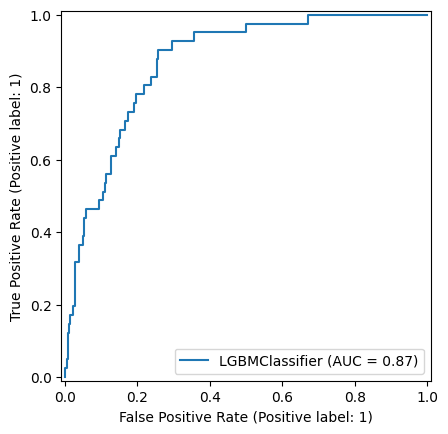

In [27]:
RocCurveDisplay.from_estimator(lgbm_clf, X_test, y_test)
# y_test: LABEL, y_test_pred: Prediction of classifier model
y_test_pred = lgbm_clf.predict(X_test)

print(accuracy_score(y_test,y_test_pred))
print(recall_score(y_test,y_test_pred,average=None))

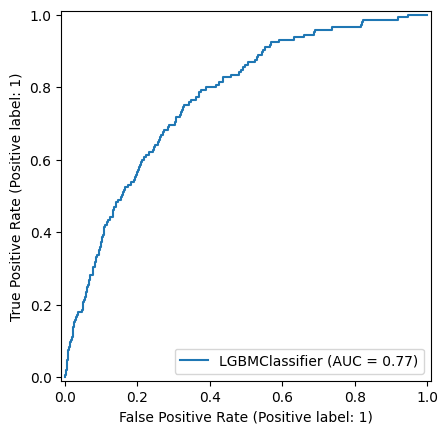

In [28]:
RocCurveDisplay.from_estimator(lgbm_clf, ext_X, ext_y)

In [29]:
lgbm_reg = LGBMRegressor(boosting_type = 'dart', num_leaves = 31, max_depth=-1, learning_rate=0.01, n_estimators=500)
lgbm_reg.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2765
[LightGBM] [Info] Number of data points in the train set: 1388, number of used features: 20
[LightGBM] [Info] Start training from score 0.064121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(boosting_type='dart', learning_rate=0.01, n_estimators=500)

### Save test sets and results to CSV

In [30]:
### Due to random samples, indices are shuffled-> reorganize sample orders and run the prediction -> save to csv
attr_x = X_test.columns
row_num = y_test.index  # 환자 번호 (CSV 파일에서 no.)
Xt = np.moveaxis(np.array(X_test.values.tolist()),0,-1)  # X_test.values.tolist() --> 645명의 환자에 대한 8 attributes에 따른 data를 list로 저장
# Xt.shape: (8, 645)
for ii in range(Xt.shape[0]):
    if ii == 0:
        x_test_re = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
    else:
        tmp = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
        x_test_re = x_test_re.join(tmp)
print(x_test_re)  #재배열된 X_test

# [HCC, name, ID] DataFrame을 생성한다
gt =  pd.DataFrame({'HCC':np.array(y_test.values.tolist())})
name = pd.DataFrame({'Name':np.array(HepatitisC_all['name'][row_num].values.tolist())})
ID = pd.DataFrame({'ID':np.array(HepatitisC_all['ID'][row_num].values.tolist())})

     Age0  Platelet0   AST0   ALT0  Bilirubin0  Albumin0     APRI0     FIB40  \
0    52.0       77.0   90.0   66.0         1.1      3.70  2.922078  7.481405   
1    59.0      135.0   47.0   30.0         0.7      4.60  0.870370  3.750209   
2    72.0      109.0   48.0   21.0         0.9      4.30  1.100917  6.918909   
3    56.0      206.0   44.0   15.0         0.5      4.10  0.533981  3.088360   
4    63.0      228.0   21.0   30.0         0.4      4.60  0.230263  1.059411   
..    ...        ...    ...    ...         ...       ...       ...       ...   
591  76.0      197.0   93.0   36.0         0.7      4.30  1.180203  5.979695   
592  64.0      150.0   45.0   60.0         0.7      4.10  0.750000  2.478709   
593  45.0      137.0  125.0  132.0         0.6      4.50  2.281022  3.573675   
594  60.0      235.0   19.0   13.0         1.0      4.30  0.202128  1.345443   
595  60.0      143.0  174.0  215.0         0.9      3.75  3.041958  4.979036   

        AMAP0  MPAGEB0  Age48  Platelet

In [31]:
results = ID.join(name)
results = results.join(x_test_re)
results = results.join(gt)

results

,ID,Name,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,...,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48,HCC
0,11686886,서○선,52.0,77.0,90.0,66.0,1.1,3.70,2.922078,7.481405,...,120.0,50.0,34.0,0.6,4.60,1.041667,3.787260,47.60211,11.0,0
1,1163990,김*도,59.0,135.0,47.0,30.0,0.7,4.60,0.870370,3.750209,...,201.0,30.0,18.0,0.5,4.80,0.373134,2.110767,50.26375,13.0,0
2,2103559,조태식,72.0,109.0,48.0,21.0,0.9,4.30,1.100917,6.918909,...,123.0,33.0,34.0,1.4,4.70,0.670732,3.358863,62.06167,17.0,0
3,1506377,박복동,56.0,206.0,44.0,15.0,0.5,4.10,0.533981,3.088360,...,188.0,19.0,17.0,0.8,4.10,0.252660,1.397160,52.30124,12.0,0
4,3242287,이*봉,63.0,228.0,21.0,30.0,0.4,4.60,0.230263,1.059411,...,205.0,13.0,12.0,0.3,4.60,0.158537,1.171599,51.69577,13.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,1843923,유을순,76.0,197.0,93.0,36.0,0.7,4.30,1.180203,5.979695,...,159.0,29.0,20.0,0.8,4.30,0.455975,3.140339,55.80975,14.0,0
592,7939391,박○심,64.0,150.0,45.0,60.0,0.7,4.10,0.750000,2.478709,...,186.0,31.0,46.0,0.8,4.30,0.416667,1.597288,49.10698,12.0,0
593,7078939,화*근,45.0,137.0,125.0,132.0,0.6,4.50,2.281022,3.573675,...,153.0,156.0,89.0,0.6,4.50,2.549020,4.971598,48.82687,10.0,0
594,2308459,공혜연,60.0,235.0,19.0,13.0,1.0,4.30,0.202128,1.345443,...,211.0,24.0,21.0,0.6,4.40,0.284360,1.514081,45.24458,11.0,0


In [32]:
test_out = lgbm_clf.predict_proba(x_test_re)[:, 1]
ext_out = lgbm_clf.predict_proba(ext_X)[:, 1]

lgbm_internal_out = pd.DataFrame({"LGBM": list(test_out)})
lgbm_external_out = pd.DataFrame({"LGBM": list(ext_out)})

INTERNAL_EXCEL = results.join(lgbm_internal_out)
EXTERNAL_EXCEL = external_results.join(lgbm_external_out)

print(INTERNAL_EXCEL)
print(EXTERNAL_EXCEL)

            ID Name  Age0  Platelet0   AST0   ALT0  Bilirubin0  Albumin0  \
0     11686886  서○선  52.0       77.0   90.0   66.0         1.1      3.70   
1      1163990  김*도  59.0      135.0   47.0   30.0         0.7      4.60   
2      2103559  조태식  72.0      109.0   48.0   21.0         0.9      4.30   
3      1506377  박복동  56.0      206.0   44.0   15.0         0.5      4.10   
4      3242287  이*봉  63.0      228.0   21.0   30.0         0.4      4.60   
..         ...  ...   ...        ...    ...    ...         ...       ...   
591    1843923  유을순  76.0      197.0   93.0   36.0         0.7      4.30   
592    7939391  박○심  64.0      150.0   45.0   60.0         0.7      4.10   
593    7078939  화*근  45.0      137.0  125.0  132.0         0.6      4.50   
594    2308459  공혜연  60.0      235.0   19.0   13.0         1.0      4.30   
595  180449701  김광애  60.0      143.0  174.0  215.0         0.9      3.75   

        APRI0     FIB40  ...  AST48  ALT48  Bilirubin48  Albumin48    APRI48  \
0    2.

In [33]:
y_test_pred = lgbm_reg.predict(x_test_re)
# np.maximum(A, B, C, ...): A, B, C, ...를 element-wise하게 비교해서 최대값 반환
y_test_pred_GB = np.maximum(y_test_pred,0)  # y_test_pred와 0을 비교한 최대값 --> 0보다 작은 값은 모두 0으로 반환 (ReLU와 비슷한 효과)

# pred = pd.DataFrame({'Prediction':np.array(y_test_pred_GB)})
# results = ID.join(name)
# results = results.join(x_test_re)
# results = results.join(gt)
# results = results.join(pred)
# print(results)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Gradient_Boosting.csv', index=False)
# results.to_excel('Results_Gradient_Boosting.xlsx', index=False)

In [34]:
# train_idx = X_train.index
# test_idx = X_test.index
# ext_idx = ext_X.index

# internal_ID = []
# external_ID = []
# for i in train_idx:
#     internal_ID.append(HepatitisC_ID_in["ID"][i])
# for j in test_idx:
#     internal_ID.append(HepatitisC_ID_in["ID"][j])
# for k in ext_idx:
#     external_ID.append(Ext_val_ID_in["ID"][k])

# train_out = lgbm_clf.predict_proba(X_train)[:,1]
# test_out = lgbm_clf.predict_proba(x_test_re)[:,1]
# ext_out = lgbm_clf.predict_proba(ext_X)[:,1]

# internal_excel = pd.DataFrame({"ID": internal_ID,
#                             "LGBM": list(train_out) + list(test_out)})
# external_excel = pd.DataFrame({"ID": external_ID,
#                                "LGBM": list(ext_out)})

# print(internal_excel)
# print(external_excel)

In [35]:
thresholds = np.linspace(0.01,0.13,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred_GB.shape),dtype = float)
    y_pred[y_test_pred>th] = 1
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.2f   |   %.2f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.2f   |   %.2f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.01       0.02333333 0.03666667 0.05       0.06333333 0.07666667
 0.09       0.10333333 0.11666667 0.13      ]
Confusion matrix: threshold - 0.010
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.43   |   0.57   | 
E  1 |    0.02   |   0.98   | 
Confusion matrix: threshold - 0.023
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.56   |   0.44   | 
E  1 |    0.05   |   0.95   | 
Confusion matrix: threshold - 0.037
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.64   |   0.36   | 
E  1 |    0.07   |   0.93   | 
Confusion matrix: threshold - 0.050
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.71   |   0.29   | 
E  1 |    0.10   |   0.90   | 
Confusion matrix: threshold - 0.063
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.77   |   0.23   | 
E  1 |    0.12   |   0.88   | 
Confusion matrix: threshold - 0.077
T    |      Prediction      | 
R    |     N     |  

## 2. Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dtree_clf = DecisionTreeClassifier()
parameters = {'max_depth':[3,5,7], 'min_samples_leaf':[5,10,15,20]}  # 이 parameter들을 dtree_clf에 입력해서 그 중의 최적의 parameter를 찾는다

dt_clf_GS = GridSearchCV(dtree_clf, parameters, cv=5)  # cv: Cross-Validation
dt_clf_GS.fit(X_train, y_train)
# dt_clf_GS.best_params_: 최적의 parameter 반환
# dt_clf_GS.best_score_: 가장 높은 성능 반환
# dt_clf_GS.best_estimator: 최적의 parameter로 RE-Trained된 estimator 모델
# dt_clf_GS.classes_: 무슨 classes를 반환하는가?

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_leaf': [5, 10, 15, 20]})

In [37]:
# dt_clf_GS.predict_proba(X: array-like) -> 무슨 확률을 예측?
print('Train AUC-ROC score is', roc_auc_score(y_train, dt_clf_GS.predict_proba(X_train)[:, 1]))
print('Test AUC-ROC score is', roc_auc_score(y_test, dt_clf_GS.predict_proba(X_test)[:, 1]))

Train AUC-ROC score is 0.8152338445303647
Test AUC-ROC score is 0.8444078224566028


In [38]:
dt_best_param = dt_clf_GS.best_estimator_
dt_best_param

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

In [39]:
dtree_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=20)
dtree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20)

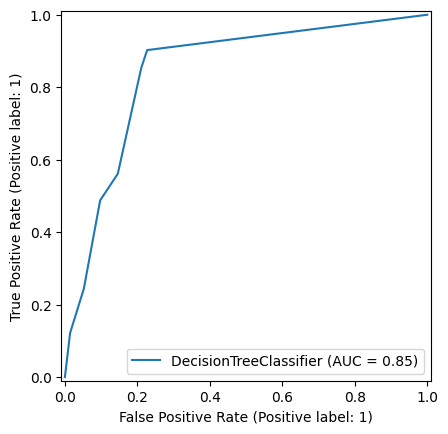

In [40]:
RocCurveDisplay.from_estimator(dtree_clf,X_test,y_test)  # .best_estimator_ 메소드 없이도 자동으로 최적의 parameter로 재학습한 estimator를 사용하는가?

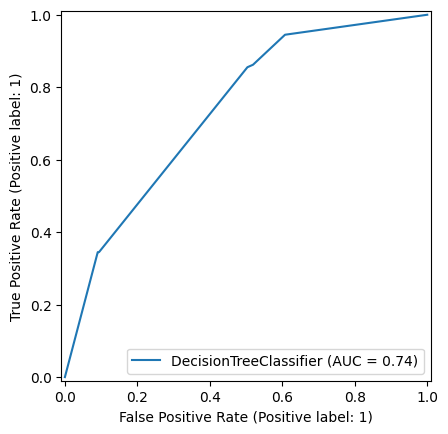

In [41]:
RocCurveDisplay.from_estimator(dtree_clf, ext_X, ext_y)

In [42]:
dtree_reg = DecisionTreeRegressor()
dt_reg_GS = GridSearchCV(dtree_reg, parameters, cv=5)
dt_reg_GS.fit(X_train, y_train)

y_test_pred = dt_reg_GS.predict(x_test_re)
y_test_pred_DT = np.maximum(y_test_pred, 0)

# pred = pd.DataFrame({'Prediction':np.array(y_test_pred_DT)})
# results = ID.join(name)
# results = results.join(x_test_re)
# results = results.join(gt)
# results = results.join(pred)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Decision_Tree.csv', index=False)
# results.to_excel('Results_Decision_Tree.xlsx', index=False)

thresholds = np.linspace(0.03,0.07,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred.shape),dtype = float)  # y_pred: 크기 (645,)의 ndarray
    y_pred[y_test_pred>th] = 1  # Prediction이 threshold보다 큰 경우에만 1로 예측 (threshold보다 낮으면 0으로 예측)
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.2f   |   %.2f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.2f   |   %.2f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.03       0.03444444 0.03888889 0.04333333 0.04777778 0.05222222
 0.05666667 0.06111111 0.06555556 0.07      ]
Confusion matrix: threshold - 0.030
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.77   |   0.23   | 
E  1 |    0.10   |   0.90   | 
Confusion matrix: threshold - 0.034
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.77   |   0.23   | 
E  1 |    0.10   |   0.90   | 
Confusion matrix: threshold - 0.039
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.77   |   0.23   | 
E  1 |    0.10   |   0.90   | 
Confusion matrix: threshold - 0.043
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.77   |   0.23   | 
E  1 |    0.10   |   0.90   | 
Confusion matrix: threshold - 0.048
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.77   |   0.23   | 
E  1 |    0.10   |   0.90   | 
Confusion matrix: threshold - 0.052
T    |      Prediction      | 
R    |     N     |  

In [43]:
test_out = dtree_clf.predict_proba(x_test_re)[:, 1]
ext_out = dtree_clf.predict_proba(ext_X)[:, 1]

dtree_internal_out = pd.DataFrame({"D_Tree": list(test_out)})
dtree_external_out = pd.DataFrame({"D_Tree": list(ext_out)})

INTERNAL_EXCEL = INTERNAL_EXCEL.join(dtree_internal_out)
EXTERNAL_EXCEL = EXTERNAL_EXCEL.join(dtree_external_out)

print(INTERNAL_EXCEL)
print(EXTERNAL_EXCEL)

            ID Name  Age0  Platelet0   AST0   ALT0  Bilirubin0  Albumin0  \
0     11686886  서○선  52.0       77.0   90.0   66.0         1.1      3.70   
1      1163990  김*도  59.0      135.0   47.0   30.0         0.7      4.60   
2      2103559  조태식  72.0      109.0   48.0   21.0         0.9      4.30   
3      1506377  박복동  56.0      206.0   44.0   15.0         0.5      4.10   
4      3242287  이*봉  63.0      228.0   21.0   30.0         0.4      4.60   
..         ...  ...   ...        ...    ...    ...         ...       ...   
591    1843923  유을순  76.0      197.0   93.0   36.0         0.7      4.30   
592    7939391  박○심  64.0      150.0   45.0   60.0         0.7      4.10   
593    7078939  화*근  45.0      137.0  125.0  132.0         0.6      4.50   
594    2308459  공혜연  60.0      235.0   19.0   13.0         1.0      4.30   
595  180449701  김광애  60.0      143.0  174.0  215.0         0.9      3.75   

        APRI0     FIB40  ...  ALT48  Bilirubin48  Albumin48    APRI48  \
0    2.922078 

## 3. Random Forest

In [44]:
forest_clf = RandomForestClassifier()
parameters = {'max_depth':[3,5,7,9], 'min_samples_leaf':[5,10,15,20]}

f_clf_GS = GridSearchCV(forest_clf, parameters, cv=3)
f_clf_GS.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [5, 10, 15, 20]})

In [45]:
print('Train AUC-ROC score is', roc_auc_score(y_train, f_clf_GS.predict_proba(X_train)[:, 1]))
print('Test AUC-ROC score is', roc_auc_score(y_test, f_clf_GS.predict_proba(X_test)[:, 1]))

Train AUC-ROC score is 0.9783584607001063
Test AUC-ROC score is 0.8996704021094265


In [46]:
rf_best_param = f_clf_GS.best_estimator_
rf_best_param

RandomForestClassifier(max_depth=7, min_samples_leaf=5)

In [47]:
forest_clf = RandomForestClassifier(max_depth=3, min_samples_leaf=5)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=5)

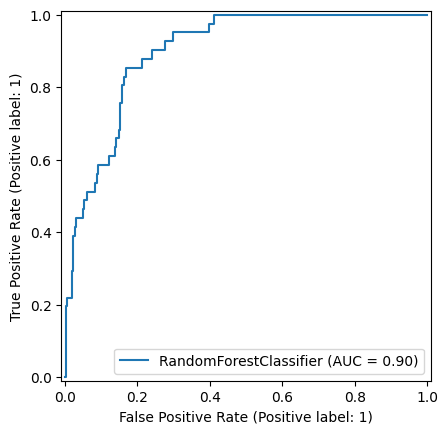

In [48]:
RocCurveDisplay.from_estimator(forest_clf,X_test,y_test)
y_test_pred_RF = forest_clf.predict_proba(x_test_re)[:, 1]

# pred = pd.DataFrame({'Prediction':np.array(y_test_pred_RF)})
# results = ID.join(name)
# results = results.join(x_test_re)
# results = results.join(gt)
# results = results.join(pred)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Random_Forest.csv', index=False)
# results.to_excel('Results_Random_Forest.xlsx', index=False)

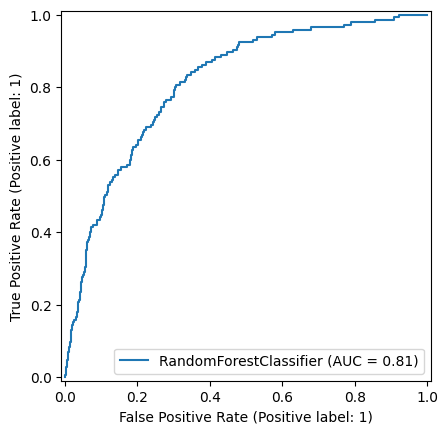

In [49]:
RocCurveDisplay.from_estimator(forest_clf, ext_X, ext_y)

In [50]:
thresholds = np.linspace(0.06,0.09,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred_RF.shape),dtype = float)
    y_pred[y_test_pred_RF>th] = 1
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.3f   |   %.3f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.3f   |   %.3f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.06       0.06333333 0.06666667 0.07       0.07333333 0.07666667
 0.08       0.08333333 0.08666667 0.09      ]
Confusion matrix: threshold - 0.060
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.714   |   0.286   | 
E  1 |    0.073   |   0.927   | 
Confusion matrix: threshold - 0.063
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.726   |   0.274   | 
E  1 |    0.098   |   0.902   | 
Confusion matrix: threshold - 0.067
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.748   |   0.252   | 
E  1 |    0.098   |   0.902   | 
Confusion matrix: threshold - 0.070
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.759   |   0.241   | 
E  1 |    0.098   |   0.902   | 
Confusion matrix: threshold - 0.073
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.771   |   0.229   | 
E  1 |    0.122   |   0.878   | 
Confusion matrix: threshold - 0.077
T    |      Prediction      | 


In [51]:
test_out = forest_clf.predict_proba(x_test_re)[:, 1]
ext_out = forest_clf.predict_proba(ext_X)[:, 1]

forest_internal_out = pd.DataFrame({"R_Forest": list(test_out)})
forest_external_out = pd.DataFrame({"R_Forest": list(ext_out)})

INTERNAL_EXCEL = INTERNAL_EXCEL.join(forest_internal_out)
EXTERNAL_EXCEL = EXTERNAL_EXCEL.join(forest_external_out)

print(INTERNAL_EXCEL)
print(EXTERNAL_EXCEL)

            ID Name  Age0  Platelet0   AST0   ALT0  Bilirubin0  Albumin0  \
0     11686886  서○선  52.0       77.0   90.0   66.0         1.1      3.70   
1      1163990  김*도  59.0      135.0   47.0   30.0         0.7      4.60   
2      2103559  조태식  72.0      109.0   48.0   21.0         0.9      4.30   
3      1506377  박복동  56.0      206.0   44.0   15.0         0.5      4.10   
4      3242287  이*봉  63.0      228.0   21.0   30.0         0.4      4.60   
..         ...  ...   ...        ...    ...    ...         ...       ...   
591    1843923  유을순  76.0      197.0   93.0   36.0         0.7      4.30   
592    7939391  박○심  64.0      150.0   45.0   60.0         0.7      4.10   
593    7078939  화*근  45.0      137.0  125.0  132.0         0.6      4.50   
594    2308459  공혜연  60.0      235.0   19.0   13.0         1.0      4.30   
595  180449701  김광애  60.0      143.0  174.0  215.0         0.9      3.75   

        APRI0     FIB40  ...  Bilirubin48  Albumin48    APRI48    FIB448  \
0    2.9220

In [52]:
# INTERNAL_EXCEL.to_excel("HCC_Prediction(Internal).xlsx", index=True)
EXTERNAL_EXCEL.to_excel("HCC_Prediction(External).xlsx", index=True)

## AUROC with 95% confidence interval

In [53]:
import sklearn.metrics
import numpy as np
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import pandas as pd

import calc_froc

In [54]:
from calc_froc import plot_roc_with_ci,plot_roc_with_ci

In [55]:
from typing import List, Tuple, Union, Any

In [56]:
def roc_with_ci(
    preds: np.array,
    labels: np.array,
    ci: float = 95,
    nbst: int = 1000,
    seed: Union[int, np.random.Generator] = None,
) -> dict:
    fprs, tprs, ths = sklearn.metrics.roc_curve(labels, preds)
    auc = sklearn.metrics.auc(fprs, tprs)

    # bootstrap to get confidence interval
    tpr_bst_list = []
    auc_bst_list = []
    rng = np.random.default_rng(seed)
    for i in range(nbst):
        # sampling with replacement
        ind = rng.integers(0, len(labels), len(labels))
        label_bst = labels[ind]
        pred_bst = preds[ind]

        # calculate ROC for each bootstrap
        fpr_bst, tpr_bst, _ = sklearn.metrics.roc_curve(label_bst, pred_bst)

        # resample the roc for each fprs
        tpr_sample = np.interp(fprs, fpr_bst, tpr_bst)
        tpr_bst_list.append(tpr_sample)
        auc_bst_list.append(sklearn.metrics.auc(fpr_bst, tpr_bst))

    tpr_bst_list = np.array(tpr_bst_list)
    tprs_ci = np.percentile(tpr_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2], axis=0)
    auc_ci = np.percentile(auc_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2])

    return {
        'fprs': fprs,
        'tprs': tprs,
        'ths': ths,
        'tprs_ci': tprs_ci,
        'auc': auc,
        'auc_ci': auc_ci
    }

def roc_with_ci_draw(pred,gt,save_fig_name):
    results = roc_with_ci(np.array(pred),np.array(gt))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    linestyle_cycle = ['-', '--']
    fig, ax = plt.subplots(figsize=[6, 4], dpi=300)
    
    color = colors[0]
    linestyle = linestyle_cycle[0]
    
    ax = plot_roc_with_ci(
        ax, results['fprs'], results['tprs'], results['tprs_ci'], color=color, linestyle=linestyle
    )
    
    ax.set_xlabel('False positive')
    ax.set_ylabel('True positive')
    ax.grid(True)
    ax.set_xlim([-0.03, 1])
    ax.set_ylim([-0.03, 1.03])
    ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)
    # plt.savefig(save_fig_name)  # FROC plot 저장
    plt.show()

<>:61: SyntaxWarning: invalid escape sequence '\p'
<>:61: SyntaxWarning: invalid escape sequence '\p'
C:\Users\김현종\AppData\Local\Temp\ipykernel_6424\1492191649.py:61: SyntaxWarning: invalid escape sequence '\p'
  ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)


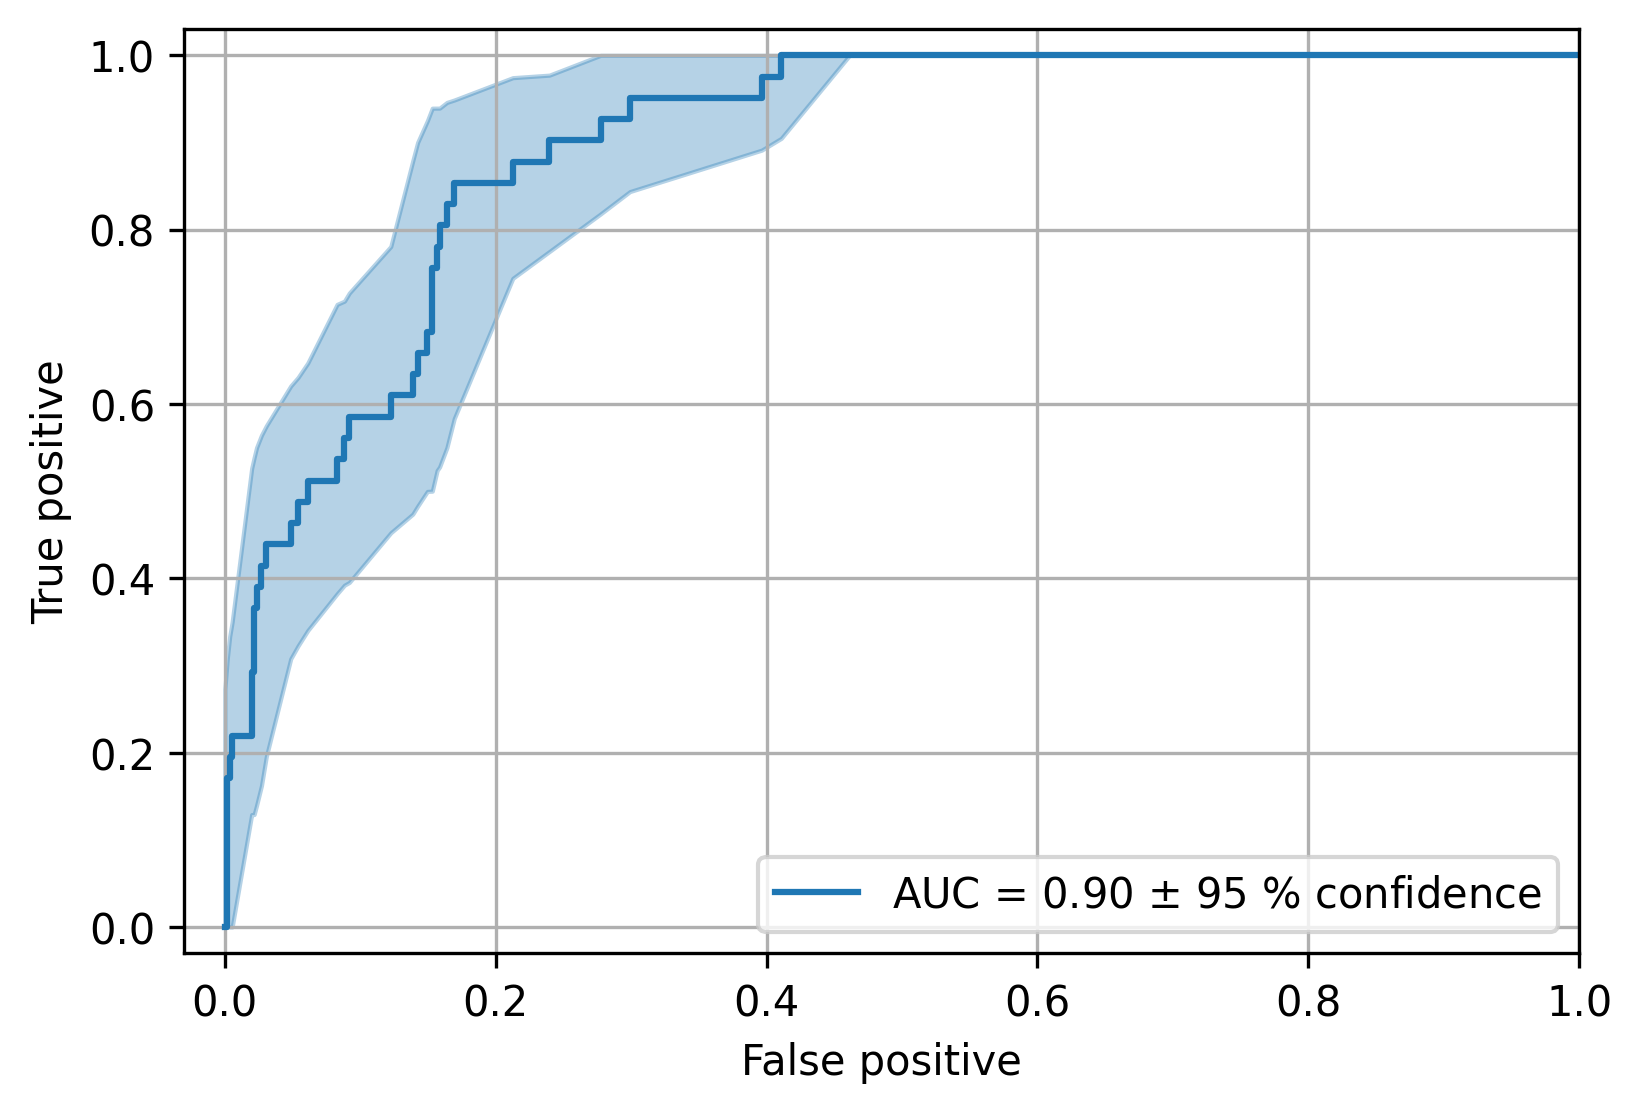

In [57]:
roc_with_ci_draw(y_test_pred_RF,gt,'RandomForest')

In [58]:
ext_gt =  pd.DataFrame({'HCC':np.array(ext_y.values.tolist())})

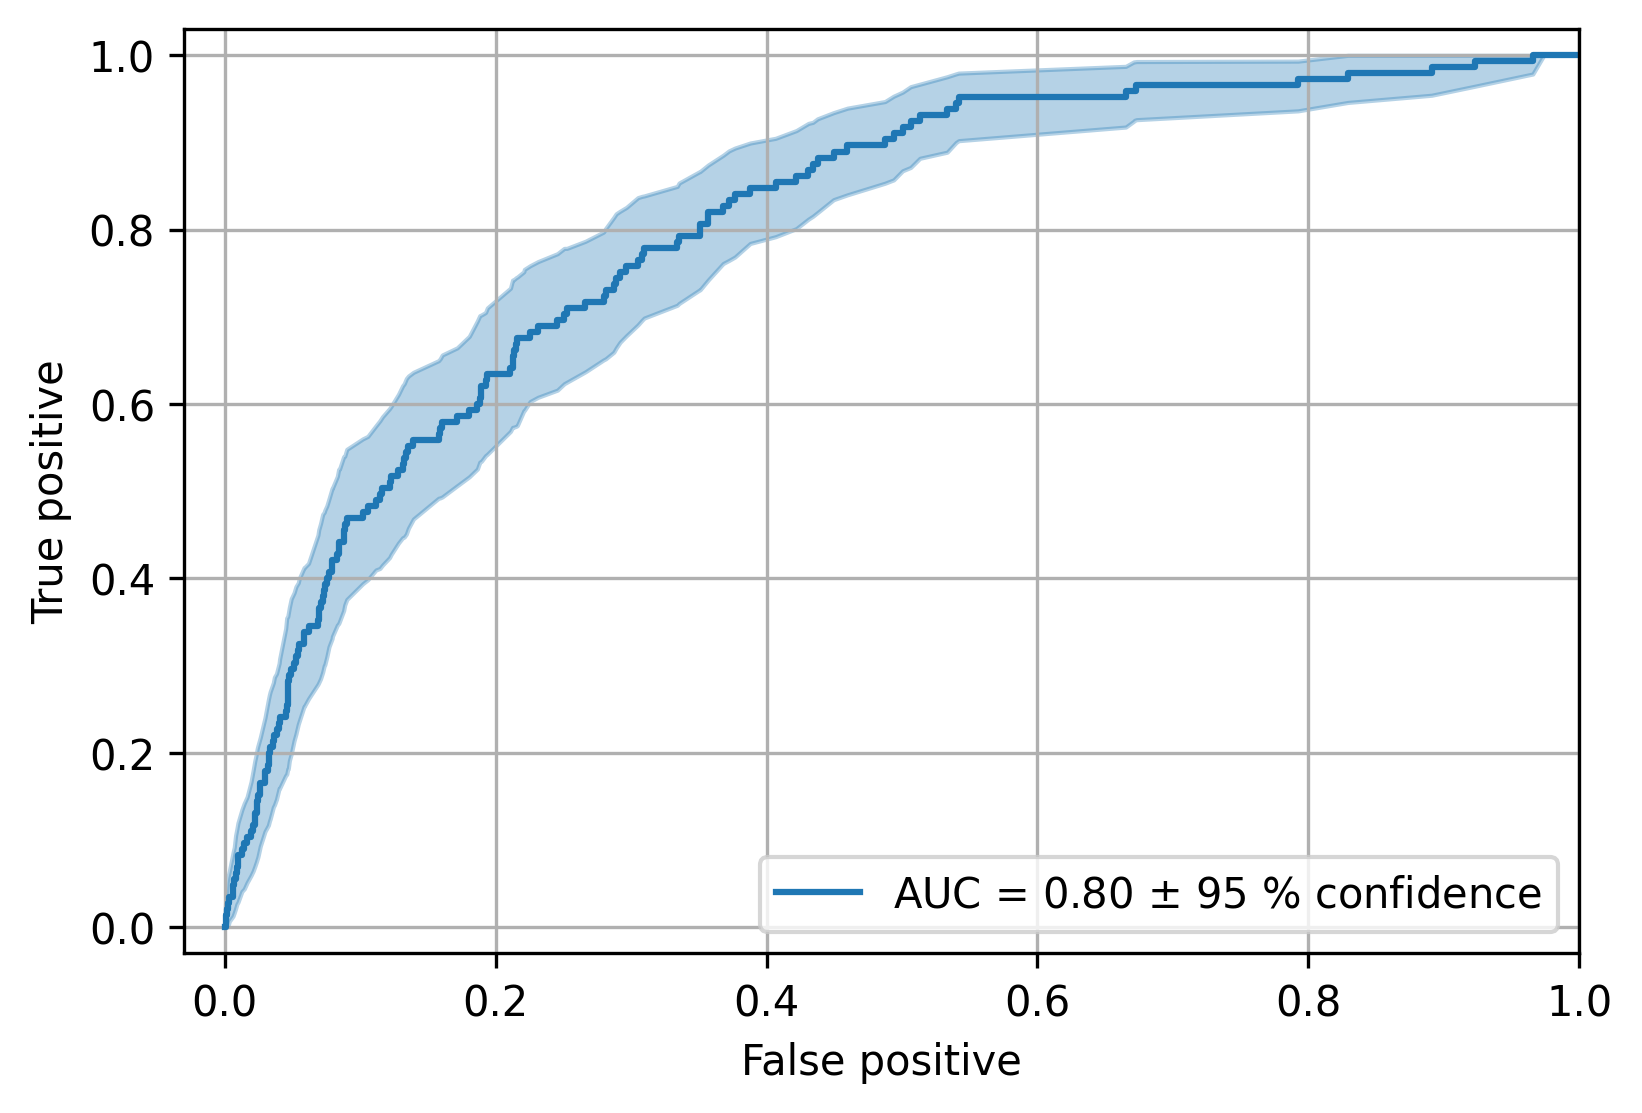

In [59]:
## External Validation 데이터로 신뢰구간 ROC 그리기 ###
ext_y_pred_RF = f_clf_GS.predict_proba(ext_X)[:, 1]
roc_with_ci_draw(ext_y_pred_RF, ext_gt, 'RandomForest')